In [106]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
train = pd.read_csv("train.csv") # we will be doing 80-20 train test split
test = pd.read_csv("test.csv") # for the actual competition

full_data = [train, test]


In [108]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [109]:
# Cabin has too many null values, so we can drop it
# Passenger Id and Ticket are pretty unique for each individual and are used merely for identification, not helping us in our model
for dataset in full_data:
    dataset.drop(["PassengerId", "Ticket", "Cabin"], axis = 1, inplace= True)

In [110]:
# filling null values 
for dataset in full_data:
    col_means = dataset.mean()
    dataset.fillna(col_means)

    dataset["Embarked"] = dataset["Embarked"].fillna("S")

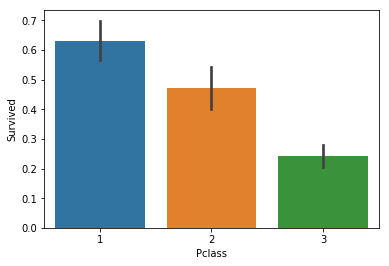

In [111]:
sns.barplot('Pclass','Survived', data=train)
plt.show()

We can see that Pclass can tell us the likelihood of survival pretty well, so we want to use Pclass in our model. Passengers from Pclass 1 had the highest survival rate, which makes sense as wealthier people had better chances of survival

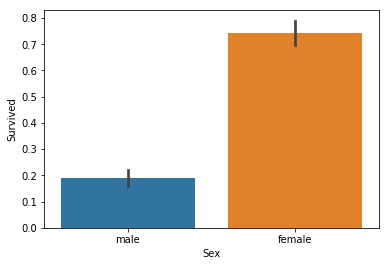

In [112]:
sns.barplot(x='Sex', y='Survived', data=train)
plt.show()

Sex is also an important feature in relationship to survival. As expected, females had a much higher survival rate, probably because women were first prioritized to get in life boats. 

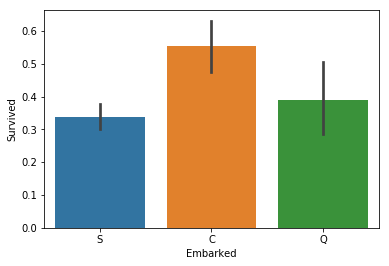

In [113]:
sns.barplot(x='Embarked', y='Survived', data=train)
plt.show()

C has the greatest survival rate. However, we do not see such stark differences in survival rates acorss the different locations. 

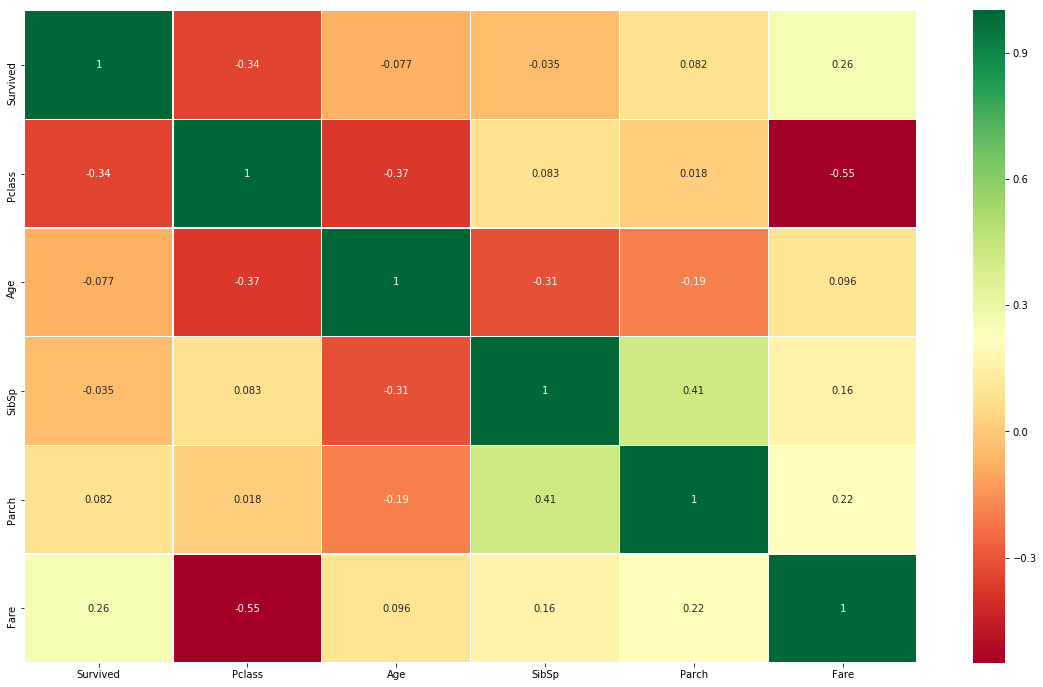

In [114]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

If there is a high correlation, then both features are containing similar information and there is little to no variance in information (multicolinearity). When training the model, it's important to eliminate redundant features. In this case, most of the features are not highly correlated with one another. 

The highest correlation is between Parch and SibSp. We would combine those two to engineer another feature called family size

In [115]:
# feature engineering family size (1 is added to account for the passenger) 
for dataset in full_data:
    dataset["Family_Size"] = dataset["Parch"] + dataset["SibSp"] + 1

    dataset.drop(["Parch", "SibSp"], axis = 1, inplace = True)

Additionally, the names do not provide much value. However, the title of these names do. 

In [116]:
# making new feature - title from Name
for dataset in full_data:
    dataset["Name"] = dataset.apply(lambda x: x["Name"][x["Name"].index(",") + 1:x["Name"].index(".")].strip(), axis = 1)
    dataset["Name"] = dataset.apply(lambda x: "Miss" if (x["Name"] == "Mlle") else x["Name"], axis = 1)
    dataset["Name"] = dataset.apply(lambda x: "Miss" if (x["Name"] == "Ms") else x["Name"], axis = 1)
    dataset["Name"] = dataset.apply(lambda x: "Mrs" if (x["Name"] == "Mme") else x["Name"], axis = 1)   

    rare_class = ["Dr", "Rev", "Major", "Col", "Sir", "Lady", "Jonkheer", "the Countess", "Don", "Capt", "Dona"]
    dataset["Name"] = dataset.apply(lambda x: "Rare" if (x["Name"] in rare_class) else x["Name"], axis = 1)

In [117]:
for dataset in full_data:
    dataset["Title"] = dataset["Name"]
    dataset.drop(["Name"], axis = 1, inplace = True)

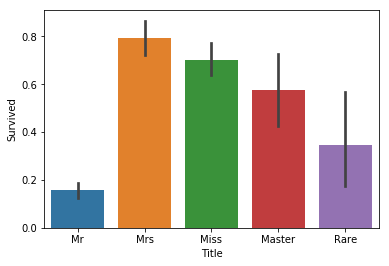

In [118]:
sns.barplot(x='Title', y='Survived', data=train)
plt.show()

We can see that there is a difference in the survival rates between the titles. As we saw in another visualization, the females have a much greater survival rate than others. 

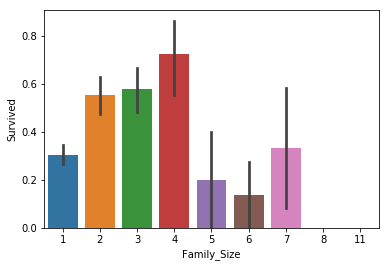

In [119]:
sns.barplot(x='Family_Size', y='Survived', data=train)
plt.show()


From the visualization above, we can conclude that that survival percentages are higher for family sizes of 2,3,and 4. They become less when family size is greater than 4 or when one is alone.

In [120]:
for dataset in full_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins = [ 0, 5, 12, 18, 24, 35, 60, np.inf], labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior'])

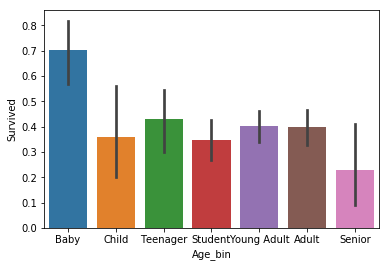

In [121]:
sns.barplot(x='Age_bin', y='Survived', data=train)
plt.show()

Babies have the highest chance of survivial out of all the age groups

In [122]:
for dataset in full_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low','AverageOne',
                                                                                      'AverageTwo','High'])

In [123]:
for dataset in full_data:
    dataset["Family_bin"] = pd.cut(dataset["Family_Size"], bins = [-1, 0, 2, 3, 5, 6, np.inf], labels = [1, 2, 3, 4, 5, 6])


The final step for our data preprocessing is one hot encoding, that is each categorical variable is converted into a binary value of many columns as seen below

In [124]:
y = train["Survived"]
train.drop(["Age", "Fare", "Family_Size", "Survived"], axis = 1, inplace = True)
train = pd.get_dummies(train, columns=['Pclass','Sex','Age_bin','Embarked','Title','Family_bin','Fare_bin'], prefix=['Pclass','Sex'
                                                                ,'Age_bin','Embarked','Title','Family_bin','Fare_bin'])

In [125]:
train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_bin_Baby,Age_bin_Child,Age_bin_Teenager,Age_bin_Student,Age_bin_Young Adult,...,Family_bin_1,Family_bin_2,Family_bin_3,Family_bin_4,Family_bin_5,Family_bin_6,Fare_bin_Low,Fare_bin_AverageOne,Fare_bin_AverageTwo,Fare_bin_High
0,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [126]:
train_X, test_X, train_y, test_y = train_test_split(train, y, test_size = 0.2, random_state = 1)

In [127]:
# create our model 
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
model.score(test_X, test_y)

0.81005586592178769

The accuracy of a model does not always tell the full story. For classification problems, we have a variety of performance metrics to evaluate our model.

The cross validated score for Random Forest Classifier is: 83.5


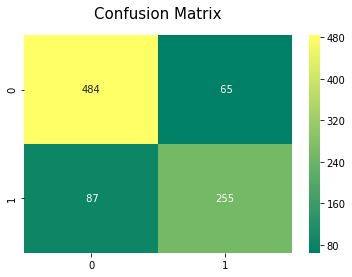

In [129]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix

kfold = KFold(n_splits = 10, random_state = 22) # k=10, split the data into 10 equal parts
result_rm=cross_val_score(model, train, y, cv=10, scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))

y_pred = cross_val_predict(model, train, y, cv=10)
sns.heatmap(confusion_matrix(y,y_pred), annot=True, fmt='3.0f', cmap="summer")
plt.title('Confusion Matrix', y=1.05, size=15)
plt.show()

Confusion Matrix gives us what the model predicted vs the correct result

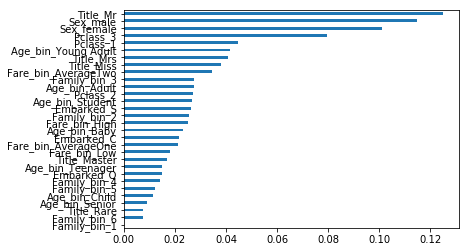

In [131]:
# Here we can see the importance of the featuers in our model 
pd.Series(model.feature_importances_,train_X.columns).sort_values(ascending=True).plot.barh(width=0.4)
plt.show()